In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel

from scipy.spatial.distance import cdist
from skdim.id import MLE

from tqdm import tqdm

from GPTID.IntrinsicDim import PHD

/home/vlad/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [109]:
### Insert here path to model files in your syste,
model_path = 'roberta-base' 
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaModel.from_pretrained(model_path)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
"""
Our method (PHD) is stochastic, here are some magic constants for it. They are chosen specifically for text data. If you plan to use this code for something different, consider testing other values.

MIN_SUBSAMPLE       --- the size of the minimal subsample to be drawn in procedure. Lesser values yields less statisitcally stable predictions.
INTERMEDIATE_POINTS --- number of sumsamples to be drawn. The more this number is, the more stable dimension estimation for single text is; however,  the computational time is higher, too. 7 is, empirically, the best trade-off.
"""
MIN_SUBSAMPLE = 40 
INTERMEDIATE_POINTS = 7


In [47]:


'''
Auxillary function. Clear text from linebreaks and odd whitespaces, because they seem to interfer with LM quite a lot.
Replace with a more sophisticated cleaner, if needed.
'''

def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')


def get_embeds(text):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    return outp[0][0].numpy()[1:-1]

In [23]:
'''
Get PHD for one text
Parameters:
        text  --- text
        solver --- PHD computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Persistence Homology Dimension method.'''
def get_phd_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)
    
    # We omit the first and last tokens (<CLS> and <SEP> because they do not directly correspond to any part of the)
    mx_points = inputs['input_ids'].shape[1] - 2

    
    mn_points = MIN_SUBSAMPLE
    step = ( mx_points - mn_points ) // INTERMEDIATE_POINTS
        
    return solver.fit_transform(outp[0][0].numpy()[1:-1],  min_points=mn_points, max_points=mx_points - step, \
                                point_jump=step)

'''
Get PHD for all texts in df[key] Pandas DataSeries (PHD method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
        alpha --- Parameter alpha for PHD computattion

Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Persistence Homology Dimension method.
'''

def get_phd(df, key='text', is_list=False, alpha=1.0, regression_type='vanilla'):
    dims = []
    PHD_solver = PHD(alpha=alpha, metric='euclidean', n_points=9, regression_type=regression_type)
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
#         print("text ===============:", text)
        dims.append(get_phd_single(text, PHD_solver))

    return np.array(dims).reshape(-1, 1)

In [6]:
'''
Get MLE for one text
Parameters:
        text  --- text
        solver --- MLE computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Maximum Likelihood Estimation method.'''
def get_mle_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    return solver.fit_transform(outp[0][0].numpy()[1:-1])

'''
Get PHD for all texts in df[key] Pandas DataSeries (PHD method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Maximum Likelihood Estimation method.
'''

def get_mle(df, key='text', is_list=False):
    dims = []
    MLE_solver = MLE()
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
        print(text)
        dims.append(get_mle_single(text, MLE_solver))

    return np.array(dims).reshape(-1, 1)


In [7]:
sample_text = "Speaking of festivities, there is one day in China that stands unrivaled - the first day of the Lunar New Year, commonly referred to as the Spring Festival. Even if you're generally uninterested in celebratory events, it's hard to resist the allure of the family reunion dinner, a quintessential aspect of the Spring Festival. Throughout the meal, family members raise their glasses to toast one another, expressing wishes for happiness, peace, health, and prosperity in the upcoming year."
df = pd.DataFrame({'text': [sample_text]})

In [8]:
from tqdm import tqdm


def sample_dims(text, n_tries, regression_type='huber'):
    dims = []
    alpha = 1.0
    PHD_solver = PHD(alpha=alpha, metric='euclidean', n_points=9, regression_type=regression_type)
    for _ in tqdm(range(n_tries)):
        dims.append(get_phd_single(sample_text, PHD_solver))
    return dims

In [9]:
# huber_dims = sample_dims(sample_text, 100)
# vanilla_dims = sample_dims(sample_text, 100, 'vanilla')
# print("huber mean and std: ", np.mean(huber_dims), np.std(huber_dims))
# print("vanilla mean and std: ", np.mean(vanilla_dims), np.std(vanilla_dims))

In [24]:
reddit_data = pd.read_json("GPTID/data/human_gpt2_wikip.json_pp", lines=True)

goldman_completion = []
gen_completion = []
for value in tqdm(reddit_data.iloc[0]):
#     print(value)
    goldman_completion.append(value['gold_completion'])
    gen_completion.append(value['gen_completion'])

reddit_data = pd.DataFrame({'gold_completion': goldman_completion, 'gen_completion': gen_completion})

n_samples = 50
human_phd_train_en_vanilla = get_phd(reddit_data.iloc[:n_samples], key='gold_completion', regression_type='vanilla', is_list=False)
human_phd_train_en_huber = get_phd(reddit_data.iloc[:n_samples], key='gold_completion', regression_type='huber', is_list=False)
opt_phd_train_en_vanilla = get_phd(reddit_data.iloc[:n_samples], key='gen_completion', regression_type='vanilla',is_list=True)
opt_phd_train_en_huber = get_phd(reddit_data.iloc[:n_samples], key='gen_completion', regression_type='huber', is_list=True)


100%|███████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


In [29]:
print("vanilla_true: ", human_phd_train_en_vanilla.mean(), human_phd_train_en_vanilla.std())
print("huber_true: ", human_phd_train_en_huber.mean(), human_phd_train_en_huber.std())
print("vanilla_gen: ", opt_phd_train_en_vanilla.mean(), opt_phd_train_en_vanilla.std())
print("huber_gen: ", opt_phd_train_en_huber.mean(), opt_phd_train_en_huber.std())

vanilla_true:  9.572074432471101 1.1602436765047581
huber_true:  9.562067235364218 1.1944484057669993
vanilla_gen:  7.951689534884026 1.4350760392357815
huber_gen:  7.9639939088442055 1.4857985801497802


In [38]:
## union two different texts:
df = reddit_data.iloc[:n_samples]
new_gold_list = []
new_gen_list = []
for i in range(n_samples):
    idx = np.random.choice(n_samples)
    while idx == i:
        idx = np.random.choice(n_samples)
    new_gold = df['gold_completion'].iloc[i] + df['gold_completion'].iloc[idx] 
    new_gen = ['.'.join(df['gen_completion'].iloc[i] + df['gen_completion'].iloc[idx])] 
    new_gold_list.append(new_gold)
    new_gen_list.append(new_gen)

df['union_gold_completion'] = new_gold_list
df['union_gen_completion'] = new_gen_list

In [40]:
human_union = get_phd(df, key='union_gold_completion', regression_type='vanilla', is_list=False)
gpt_union = get_phd(df, key='union_gen_completion', regression_type='vanilla', is_list=True)

100%|███████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


In [41]:
print("human_union: ", human_union.mean(), human_union.std())
print("gpt_union: ", gpt_union.mean(), gpt_union.std())

human_union:  9.925960627389474 0.9322940770137641
gpt_union:  8.535691857562348 1.0340845170181747


In [ ]:
## hurst

In [42]:
!pip3 install GenHurst

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement GenHurst (from versions: none)
ERROR: No matching distribution found for GenHurst


In [43]:
from hurst import generalized_hurst_exp

In [51]:
text = df['gold_completion'].iloc[0]

In [89]:
from collections import defaultdict


def get_stats(text):
    embeds = get_embeds(text)
    df_stats = dict()#defaultdict(list)
    hurst_exps_human = []
    for i in tqdm(range(768)):
        hurst_exp = generalized_hurst_exp(embeds[:, i], 2)
        hurst_exps_human.append(hurst_exp)
    
    df_stats['mean'] = np.mean(hurst_exps_human)
    df_stats['min'] = np.min(hurst_exps_human)
    df_stats['max'] = np.max(hurst_exps_human)
    df_stats['std'] = np.std(hurst_exps_human)

    return df_stats

In [94]:
def loop_texts_hurst_exp(texts):
    lst = []
    for text in texts:
        if type(text) is list:
            text = text[0]
        lst.append(get_stats(text))

    return lst

In [ ]:
result = loop_texts_hurst_exp(df['gold_completion'].values.tolist()[:50])

In [ ]:
pd.DataFrame(result)

In [98]:
result_gpt = loop_texts_hurst_exp(df['gen_completion'].values.tolist()[:50])

 56%|██████████████████████▏                 | 427/768 [00:03<00:03, 111.52it/s]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame(result_gpt)

In [99]:
## add_one world delete one world

In [125]:
from nltk.tokenize import word_tokenize

tokenized = word_tokenize(text)
df_example = pd.DataFrame({'text': [text]})
true_phd = get_phd(df_example)[0][0]
word2diff_phd = dict()
for i in tqdm(range(len(tokenized))):
    new_text = text.replace(tokenized[i], '')# ' '.join(tokenized[:i] + tokenized[i + 1:])
    df_new = pd.DataFrame({'text': [new_text]})
    new_phd = get_phd(df_new)[0][0]
    word2diff_phd[tokenized[i]] = true_phd - new_phd

df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|█████████████████████████████████████████| 400/400 [06:42<00:00,  1.01s/it]


In [134]:
df_stats2.median()

diff_phd    0.264773
dtype: float64

In [130]:
df_stats2.std()

diff_phd    0.263792
dtype: float64

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

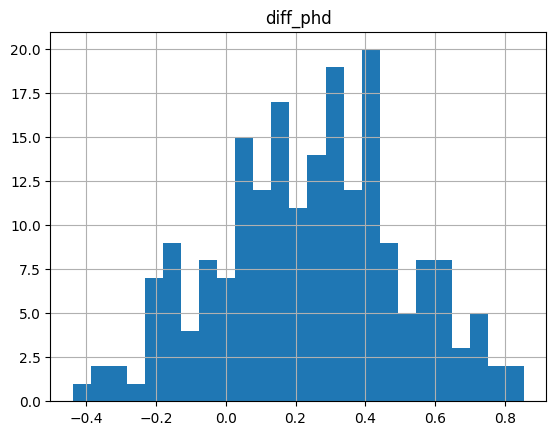

In [133]:
df_stats2.hist(bins=25)

In [143]:
from nltk.tokenize import word_tokenize


text = df['gen_completion'].iloc[0][0]
tokenized = word_tokenize(text)
df_example = pd.DataFrame({'text': [text]})
true_phd = get_phd(df_example)[0][0]
word2diff_phd = dict()
for i in tqdm(range(len(tokenized))):
    new_text = text.replace(tokenized[i], '')# ' '.join(tokenized[:i] + tokenized[i + 1:])
    df_new = pd.DataFrame({'text': [new_text]})
    new_phd = get_phd(df_new)[0][0]
    word2diff_phd[tokenized[i]] = true_phd - new_phd

df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|█████████████████████████████████████████| 270/270 [02:23<00:00,  1.89it/s]


array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

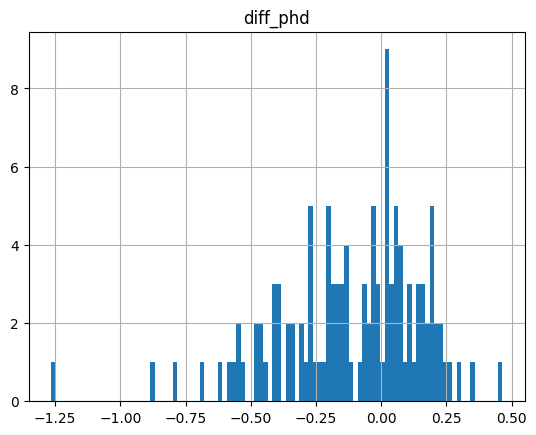

In [145]:
df_stats2.hist(bins=100)

In [146]:
df_stats2.mean()

diff_phd   -0.115154
dtype: float64

In [148]:
from nltk.tokenize import word_tokenize


text = df['gen_completion'].iloc[1][0]
tokenized = word_tokenize(text)
df_example = pd.DataFrame({'text': [text]})
true_phd = get_phd(df_example)[0][0]
word2diff_phd = dict()
for i in tqdm(range(len(tokenized))):
    new_text = text.replace(tokenized[i], '')# ' '.join(tokenized[:i] + tokenized[i + 1:])
    df_new = pd.DataFrame({'text': [new_text]})
    new_phd = get_phd(df_new)[0][0]
    word2diff_phd[tokenized[i]] = true_phd - new_phd

df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|█████████████████████████████████████████| 237/237 [02:03<00:00,  1.92it/s]


array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

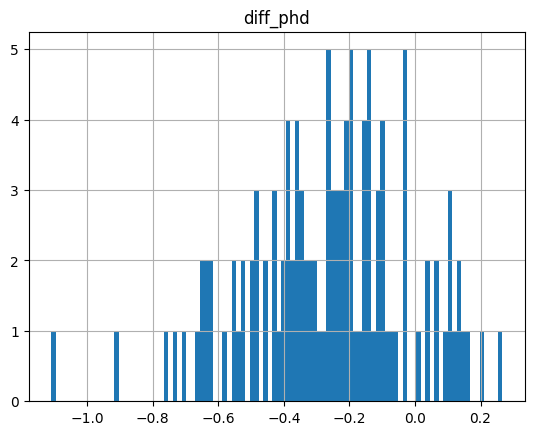

In [149]:
df_stats2.hist(bins=100)

In [150]:
df_stats2.mean()

diff_phd   -0.266626
dtype: float64

In [ ]:
from nltk.tokenize import word_tokenize


word2diff_phd = dict()
for _ in tqdm(range(40)):
    text = df['gold_completion'].iloc[np.random.choice(df.shape[0])]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]
    
    for i in np.random.choice(len(tokenized), size=10):
        new_text =' '.join([word for word in tokenized if word != tokenized[i]])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

In [183]:
df_stats2['diff_phd'].mean()

0.05856073329645392

<Axes: >

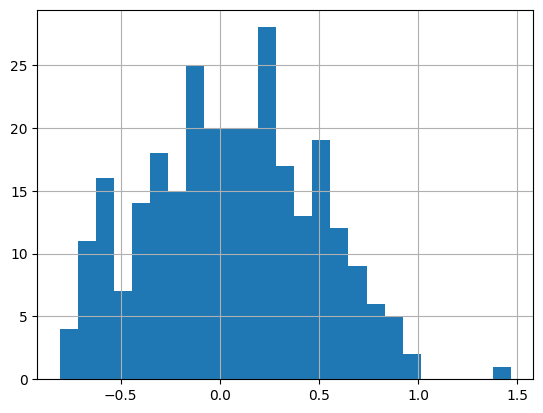

In [184]:
df_stats2['diff_phd'].hist(bins=25)

In [185]:
df_stats2.shape

(282, 1)

In [ ]:
from nltk.tokenize import word_tokenize

word2diff_phd = dict()
for _ in tqdm(range(40)):
    text = df['gen_completion'].iloc[np.random.choice(df.shape[0])][0]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]

    for i in np.random.choice(len(tokenized), size=10):
        new_text =' '.join([word for word in tokenized if word != tokenized[i]])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats3 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

In [190]:
df_stats3.std(), df_stats3.mean(), df_stats3.median()

(diff_phd    0.672169
 dtype: float64,
 diff_phd    0.013695
 dtype: float64,
 diff_phd   -0.025519
 dtype: float64)

In [191]:
df_stats2.std(), df_stats2.mean(), df_stats2.median()

(diff_phd    0.421716
 dtype: float64,
 diff_phd    0.058561
 dtype: float64,
 diff_phd    0.062066
 dtype: float64)

In [188]:
df_stats2.shape

(282, 1)

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

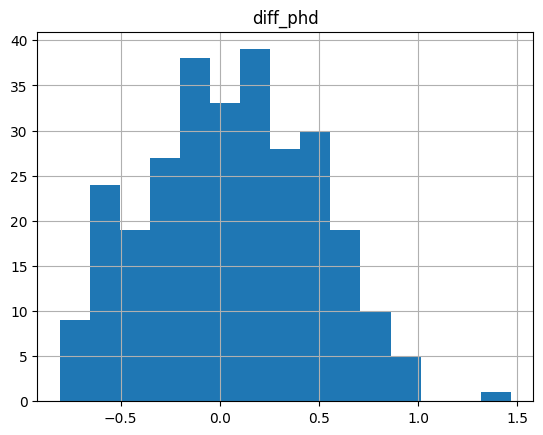

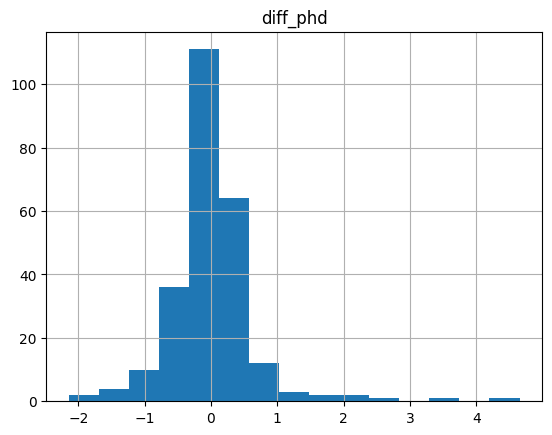

In [192]:
df_stats2.hist(bins=15)
df_stats3.hist(bins=15)

In [195]:
df_stats3.sort_values(by='diff_phd')# .head(40)

,diff_phd
and,-2.144817
"World.""",-2.082449
"""It's",-1.542778
"""All",-1.349877
artists.,-1.323473
...,...
By,2.038670
Resolution,2.245490
Assembly,2.756448
Gough,3.481285
